In [74]:
import numpy as np
import scipy as sp
import sklearn
import sklearn.pipeline
import sklearn.metrics

import econml.sklearn_extensions.linear_model as lin_model
import matplotlib.pyplot as plt

In [75]:
P = 3
M = 1
N = 100
K = 2

S_s = 0.4
S_c = 0.2

sc =[0.8,0.2,0.5]
Sigma_nu = np.diag(sc)
Sigma_s  = np.eye(1)

gamma_s_true = np.sqrt(1-np.array(sc)[np.newaxis,:])
gamma_s_true[0,0] *= -1


beta_c_true = np.zeros((P))
beta_c_true[0] = 1/np.sqrt(sc[0])
beta_c_true[1] = 1/np.sqrt(sc[1])
beta_c_true /= np.sqrt(beta_c_true.T @ Sigma_nu @ beta_c_true)
beta_c_true *= np.sqrt(S_c)

beta_s_true = np.sqrt(S_s)-(gamma_s_true @ beta_c_true)

beta_s_star_true = beta_s_true + (gamma_s_true @ beta_c_true)

sig2 = (1 - S_s - S_c)*np.eye(1)

eps = np.random.multivariate_normal(mean=np.zeros(1), cov=sig2, size=N)
nu  = np.random.multivariate_normal(mean=np.zeros(P), cov=Sigma_nu, size=N)
S   = np.random.multivariate_normal(mean=np.zeros(M), cov=Sigma_s, size=N)
Z   = S@gamma_s_true + nu

Y_r_true = (nu @ beta_c_true)[:,np.newaxis] + eps
Y1 = (S @ beta_s_true + Z @ beta_c_true)[:,np.newaxis]  + eps
Y2 = (S @ beta_s_star_true + nu @ beta_c_true)[:,np.newaxis] + eps


model = sklearn.linear_model.Ridge(alpha=0.001, fit_intercept=True)
model.fit(S, Y1)
Y_r = Y1 - model.predict(S)


X = np.hstack([S,Z])
W_true = np.hstack([S,nu])

model.fit(S, Z)
nu_est = Z - model.predict(S)

W = np.hstack([S,nu_est])

# print(beta_c_true)
# print(beta_s_star_true)
# print(beta_s_true)

In [76]:
def fit(x,y,M,alphas,adaptive_weight=0):

    scaler = sklearn.preprocessing.StandardScaler()
    xn = scaler.fit_transform(x)
    yn = scaler.fit_transform(y).ravel()

    # print(np.cov(xn.T))
    if(adaptive_weight is not None and adaptive_weight > 0):
        base_model = sklearn.linear_model.Ridge(alpha=0.001, fit_intercept=False)
        base_model.fit(xn, yn)
        scales = np.power(np.abs(base_model.coef_.reshape((1,-1))),adaptive_weight)
        print(scales)
        xn *= scales
    else:
        scales = 1
        


    model_0      = sklearn.linear_model.Lasso(alpha=alphas[0],fit_intercept=False,warm_start=True,max_iter=1000)

    Bs = np.zeros((xn.shape[1],len(alphas)))
    threshold = 1e-14

    fit_a = True
    for ii, alpha in enumerate(alphas):
        if(fit_a):
            model_0.alpha = alphas[ii]
            if(M > 0):
                model      = lin_model.SelectiveRegularization(range(M), model_0, fit_intercept=False)
            else:
                model = model_0
            model.fit(xn, yn);

            Bs[:,ii]      = model.coef_.ravel() * scales
            active = np.abs(model.coef_) > threshold;
            if(np.all(~active) ):
                fit_a = False
                Bs[:M,ii:] = Bs[:M,[ii]]

    return Bs    

In [77]:

# bs_2 = fit(X,Y1,M,alphas,adaptive_weight=0.5)

In [78]:
alphas = np.logspace(-2,0,400)

bs_0 = fit(X,Y1,M,alphas)
# bs_1 = fit(W,Y1,M,alphas)
# bs_2 = fit(nu_est, Y_r,0,alphas)
bs_1 = fit(W_true,Y1,M,alphas)
bs_2 = fit(X,Y1,M,alphas,adaptive_weight=1)
bs_3 = fit(X,Y1,0,alphas)
# bs_3 = fit(W_true, Y1,M,alphas)
# bs = np.dstack([bs_0, bs_1, np.vstack([np.zeros((1,alphas.size)), bs_2]), bs_3])
bs = np.dstack([bs_0, bs_1,bs_2, bs_3])

coef_names = ["stim", "neuron 1", "neuron 2", "neuron 3 - uncorrelated"]
# fit_names = ["standard - unpenalized stim", "residual neuron", "true stim/noise separation", "standard - penalize stimulus"]
fit_names = ["standard - unpenalized stim", "residual neuron", "adaptive", "standard - penalize stimulus"]

[[0.16724293 0.3052058  0.79224769 0.02379256]]


In [79]:

# plt.figure(figsize=(bs.shape[2]*5,bs.shape[0]*4))



# for ii in range(bs.shape[2]):
#     for cc in range(bs.shape[0]):
#         plt.subplot(bs.shape[0],bs.shape[2],ii + 1 + cc*bs.shape[2])
#         plt.semilogx(alphas, bs[cc,:,ii])
#         plt.ylabel(coef_names[cc])
#         if(cc == 0):
#             plt.title(fit_names[ii])

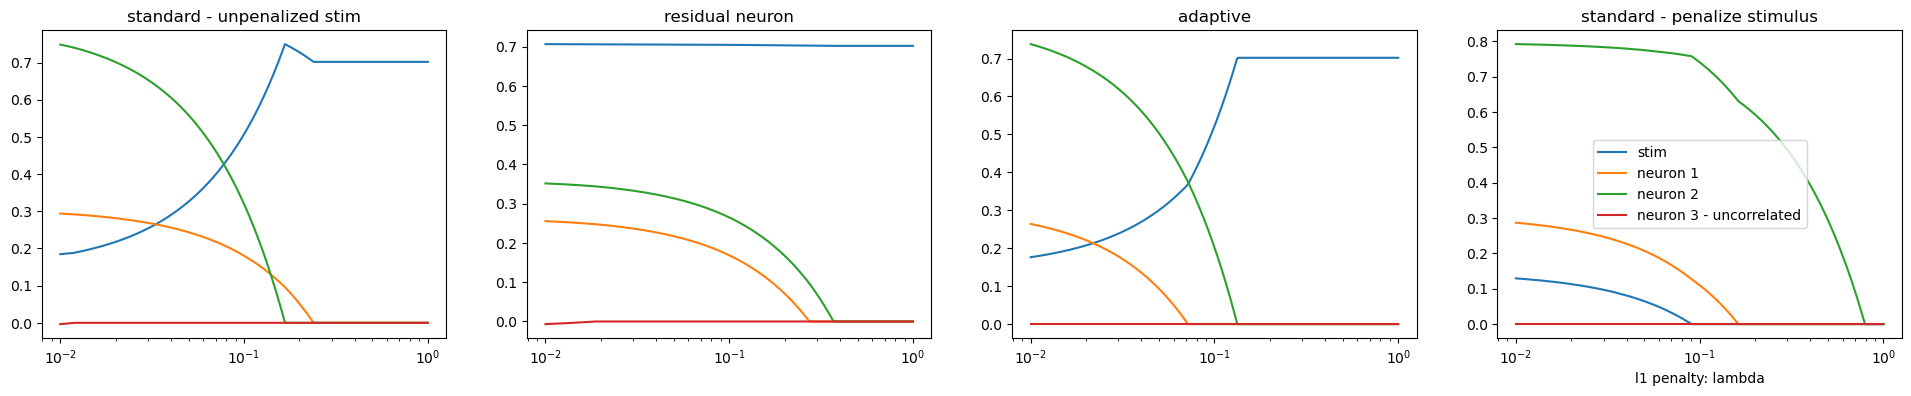

In [80]:
# bs = np.dstack([bs_0, bs_1, np.vstack([np.zeros((1,alphas.size)), bs_2]), bs_3])
bs = np.dstack([bs_0, bs_1,bs_2, bs_3])
plt.figure(figsize=(bs.shape[0]*6,4))




for ii in range(bs.shape[2]):
    plt.subplot(1,bs.shape[2],ii + 1 )
    plt.title(fit_names[ii])
    for cc in range(bs.shape[0]):
        plt.semilogx(alphas, bs[cc,:,ii], label=coef_names[cc])

plt.legend();
plt.xlabel("l1 penalty: lambda");

In [81]:
for ii in range(3): print(sp.stats.pearsonr(nu_est[:,ii],Y_r[:,0]))

PearsonRResult(statistic=0.38714190278220423, pvalue=6.918505517019889e-05)
PearsonRResult(statistic=0.5187703656378531, pvalue=3.217551773644384e-08)
PearsonRResult(statistic=-0.12780380776730854, pvalue=0.2050932457579638)


In [82]:
for ii in range(3): print(sp.stats.pearsonr(nu[:,ii],Y_r_true[:,0]))

PearsonRResult(statistic=0.38571498019546546, pvalue=7.396605451494521e-05)
PearsonRResult(statistic=0.5175851601764181, pvalue=3.5009551251151575e-08)
PearsonRResult(statistic=-0.12020980600999484, pvalue=0.23353181932353057)


In [253]:
N = 20
P = 5
M = 3

nu_0 = P+1
sigma_0 = np.eye(M)
psi_0 = np.eye(P)

W_true_psi = np.eye(P)
W_true_psi[0,0] = 8
W_true_psi[1,1] = 4

sig2 = 0.1


W_true = sp.stats.invwishart.rvs(P+1, W_true_psi)

sigma_true = sp.stats.invwishart.rvs(P+1, psi_0)
c_true = sp.stats.matrix_normal.rvs(mean=None, rowcov=sigma_0, colcov=sigma_true)

source_noise = sp.stats.multivariate_normal.rvs(mean=None, cov=W_true, size=N)

S = sp.stats.multivariate_normal.rvs(mean=None, cov=np.eye(M), size=N)

Z = S@c_true + source_noise

U_star_inv = S.T @ S + sigma_0
M_star = np.linalg.solve(U_star_inv, S.T @ Z)

nu_post = nu_0 + N
psi_post = psi_0 + (Z-S@M_star).T @ (Z-S@M_star) + M_star.T @ np.linalg.solve(sigma_0, M_star)

alpha = (nu_post - (P-1))/2
betas = np.diag(psi_post)/2
lam = 1

a_true = np.random.randn(M)
b_true = np.random.randn(P)

Y = S@a_true + source_noise@b_true + np.random.randn(N)*np.sqrt(sig2)

In [267]:
ii = 0

bs = np.linspace(0,10,100)

b_new = np.zeros((P, len(bs)))
n_err = np.zeros((P, len(bs)))
pen_err = np.zeros((P, len(bs)))

for jj in range(P):
    beta = betas[jj] 

    for ii, b_i in enumerate(bs):


        range_lower = 0.0001
        range_upper = 30

        w = 1
        exp_const = lam*np.abs(b_i)/np.sqrt(w) + beta/w

        post_proportional = lambda w : np.exp(-(lam*np.abs(b_i)/np.sqrt(w) + beta/w) + exp_const) / (w ** (alpha + 1/2))

        normalizing_const,n_err[jj,ii] = sp.integrate.quad(post_proportional,range_lower,range_upper)

        log_normalizing_const = np.log(normalizing_const)

        exp_post_proportional = lambda w : np.exp(-(lam*np.abs(b_i)/np.sqrt(w) + beta/w) + exp_const - log_normalizing_const) / (w ** (alpha + 1))
        pen,pen_err[jj,ii] = sp.integrate.quad(exp_post_proportional,range_lower,range_upper)

        b_new[jj,ii] = pen


In [207]:
exp_const

42.840367970157914

0.999882653405805

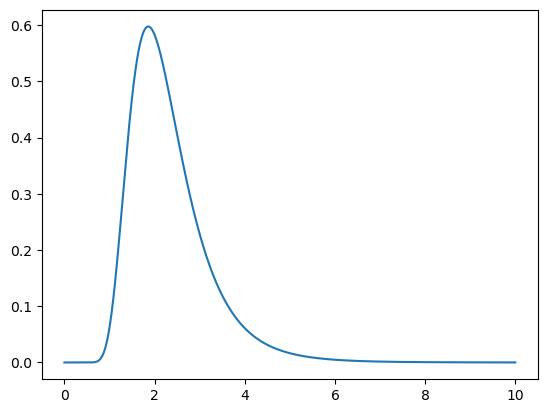

In [268]:
post_proportional2 = lambda w : 1/(w ** (alpha + 1/2)) * np.exp(-(lam*np.abs(b_i)/np.sqrt(w) + beta/w) + exp_const - log_normalizing_const)
dw = 0.001
xx = np.arange(dw,10,dw)
yy = post_proportional2(xx)
plt.plot(xx,yy);

np.sum(yy)*dw

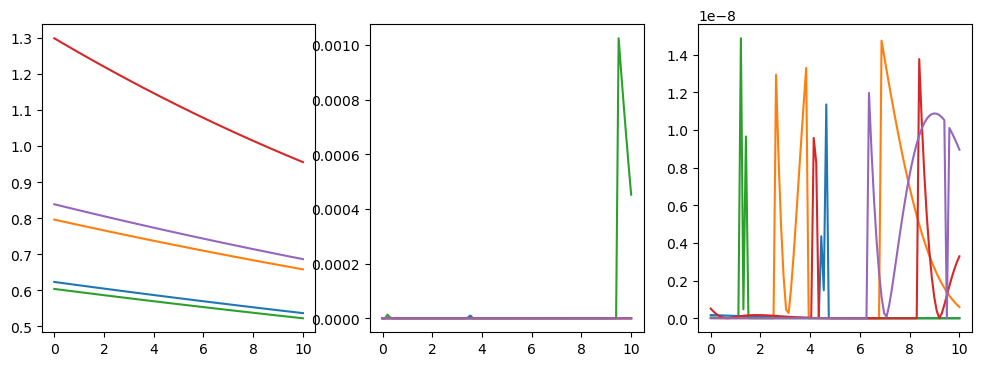

In [269]:
# plt.plot(bs,b_new.T)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(bs,b_new.T)
# plt.plot(bs[:-1],np.diff(b_new,axis=1).T)
plt.subplot(1,3,2)
plt.plot(bs,n_err.T)
plt.subplot(1,3,3)
plt.plot(bs,pen_err.T)

In [270]:
np.sqrt(np.diag(W_true))

array([1.76375998, 1.29466873, 1.94722234, 0.73103536, 1.70215014])

In [274]:
b_new[:,0]

array([0.62330127, 0.79614619, 0.60391545, 1.2989572 , 0.83874356])

In [273]:
sp.special.gamma(alpha)/sp.special.gamma(alpha-1/2)/np.sqrt(betas)

array([0.62330127, 0.79614619, 0.60391545, 1.2989572 , 0.83874356])

In [241]:
-lam + lam*alpha*(sp.special.gamma(alpha)/sp.special.gamma(alpha+1/2))**2

0.022979518563905232

In [275]:
(b_new[:,1]-b_new[:,0])/(bs[1]-bs[0])

array([-0.00935027, -0.01525177, -0.0087779 , -0.0405744 , -0.01692661])

In [260]:
[np.mean(np.sqrt(sp.stats.invgamma.rvs(alpha,scale=betas[ii],size=10000))) for ii in range(P)]

[1.6025719410164734,
 1.2509824165571675,
 1.6606173166871006,
 0.7722124743103504,
 1.1912098012495613]

In [266]:
g_e,*_ = np.linalg.lstsq(S,Z,rcond=None)
Zp = Z-S@g_e

XX = np.hstack([S,Z])
XXp = np.hstack([S,Zp])

b1,*_=np.linalg.lstsq(XX,Y,rcond=None)
b2,*_=np.linalg.lstsq(XXp,Y,rcond=None)

print(b1[:])
print(b2[:])

[ 5.30469547  0.30067862  1.45425957 -1.53610269  0.07105736  0.63422962
  1.76509731  0.32423378]
[-0.48972575  1.2625623   0.30312049 -1.53610269  0.07105736  0.63422962
  1.76509731  0.32423378]
